In [1]:
import osmnx as ox
import pandas as pd
import time
import os

import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
def forward_geocode(address):
    try:
        return ox.geocode(address)
    except:
        return None

def load_data():
    cwd = os.getcwd()
    geocoded_path = os.path.join(cwd, '..', 'data', 'interim', 'train_data_geocoded.csv')
    
    # Check if the geocoded file exists
    if os.path.exists(geocoded_path):
        df = pd.read_csv(geocoded_path)
    else:
        # If the geocoded file does not exist, create it
        df = pd.read_csv(os.path.join(cwd, '..', 'data', 'interim', 'train_data_encoded.csv'))
        df['coordinates'] = [forward_geocode(site) for site in df['Site']]
        df.to_csv(geocoded_path)
    
    return df

df = load_data()

In [3]:
df

,Start DateTime,CP ID,Connector,Total kWh,Site,Model,End DateTime,Site_encoded,Model_encoded,Total kWh.1,coordinates
0,2016-01-09 07:21:00,50994,1,2.084000,"Leslie Street Car Park, Blairgowrie",APT Triple Rapid Charger,2016-01-09 07:27:00,0.0,3.0,2.084000,None
1,2016-01-09 07:51:00,50281,2,3.870000,"Rie-Achan Road Car Park, Pitlochry",APT 22kW Dual Outlet,2016-01-09 09:01:00,19.0,0.0,3.870000,"(56.7034231, -3.738820533577715)"
2,2016-01-09 08:22:00,50285,1,13.930000,Broxden Park & Ride,APT 22kW Dual Outlet,2016-01-09 14:32:00,3.0,0.0,13.930000,"(56.386610000000005, -3.4777460635074835)"
3,2016-01-09 08:54:00,50281,1,10.380000,"Rie-Achan Road Car Park, Pitlochry",APT 22kW Dual Outlet,2016-01-09 16:37:00,19.0,0.0,10.380000,"(56.7034231, -3.738820533577715)"
4,2016-01-09 09:22:00,50745,2,3.580000,Kinross Park and Ride,APT Triple Rapid Charger,2016-01-09 09:37:00,13.0,3.0,3.580000,"(56.2067285, -3.432945)"
...,...,...,...,...,...,...,...,...,...,...,...
66659,2019-12-08 20:34:00,50838,1,10.758277,"Mill Street, Perth",APT 22kW Raption,NaN,17.0,1.0,10.758277,"(56.3975639, -3.4304505)"
66660,2019-12-08 20:47:00,51519,2,10.080000,"Broxden Park & Ride, Perth",APT Triple Rapid Charger,2019-12-08 21:15:00,4.0,3.0,10.080000,"(56.386610000000005, -3.4777460635074835)"
66661,2019-12-08 21:01:00,51249,1,4.690000,"Atholl Street Car Park, Dunkeld",Siemens Triple Rapid Charger,2019-12-08 21:17:00,2.0,6.0,4.690000,None
66662,2019-12-08 22:27:00,51249,1,14.710000,"Atholl Street Car Park, Dunkeld",Siemens Triple Rapid Charger,2019-12-08 22:50:00,2.0,6.0,14.710000,None


In [4]:
df.isna().sum().sum()

25964

In [5]:
def get_failed_addresses(df):
    # Filter DataFrame for rows where 'coordinates' is None
    failed_df = df[df['coordinates'].isna()]

    # Get unique addresses from failed_df
    unique_failed_addresses = failed_df['Site'].unique()

    return unique_failed_addresses

failed_addresses = get_failed_addresses(df)
print(failed_addresses)


[' Leslie Street Car Park, Blairgowrie' 'Friarton Depot'
 'South Inch Car Park' 'Moness Terrace Car Park, Aberfeldy'
 'Crown Inn Wynd Car Park, Auchterarder'
 'Canal Street Car Park 3rd floor ' 'Friarton Depot, Perth'
 'Canal Street Car Park 3rd floor, Perth' 'South Inch Car Park, Perth'
 'Atholl Street Car Park, Dunkeld' 'Leslie Street Car Park, Blairgowrie'
 '***TEST SITE*** Charge Your Car HQ']


In [6]:
len(failed_addresses)

12

# Search in google maps for the exact corrections:

In [7]:
corrections = {
    'Leslie Street Car Park, Blairgowrie': ('Leslie Street Car Park', (56.59132102107761, -3.338015029709677)),
    ' Leslie Street Car Park, Blairgowrie': ('Leslie Street Car Park', (56.59132102107761, -3.338015029709677)),
    'Leslie Street Car Park': ('Leslie Street Car Park', (56.59132102107761, -3.338015029709677)),
    'Friarton Depot': ('Perth & Kinross Council - Friarton Depot', (56.37659640296878, -3.4239012108677493)),
    'Friarton Depot, Perth': ('Perth & Kinross Council - Friarton Depot', (56.37659640296878, -3.4239012108677493)),
    'South Inch Car Park': ('South Inch Car Park', (56.39154009919279, -3.427360729721281)),
    'South Inch Car Park, Perth': ('South Inch Car Park', (56.39154009919279, -3.427360729721281)),
    'Moness Terrace Car Park, Aberfeldy': ('Moness Terrace Car Park, Aberfeldy', (56.62102729640193, -3.8651342146387715)),
    'Crown Inn Wynd Car Park, Auchterarder': ('Crown Inn Wynd Car Park, Auchterarder', (56.295914749883686, -3.7062371739021716)),
    'Canal Street Car Park 3rd floor': ('Canal Street Multi Storey Car Park', (56.39451242619442, -3.4297793436209987)),
    'Canal Street Car Park 3rd floor, Perth': ('Canal Street Multi Storey Car Park', (56.39451242619442, -3.4297793436209987)),
    'Canal Street Car Park 3rd floor ': ('Canal Street Multi Storey Car Park', (56.39451242619442, -3.4297793436209987)),
    'Atholl Street Car Park, Dunkeld': ('North Car Park', (56.567488239989174, -3.586580202721494)),
    '***TEST SITE*** Charge Your Car HQ': ('Chargeplace Scotland Charging Station', (56.5680670710552, -3.5864944100166487))
}


Creation of a function that iterates over your DataFrame and applies the corrections:

In [8]:
def correct_sites(df):
    for site in corrections.keys():
        df.loc[df['Site'] == site, 'Site'] = corrections[site][0]
        df.loc[df['Site'] == corrections[site][0], 'coordinates'] = str(corrections[site][1])
    return df

df = correct_sites(df)


In [9]:
df.isna().sum().sum()

185

In [10]:
def drop_nan_columns(df, threshold=0.05):
    """
    Drop columns from df where the proportion of NaN values exceeds the threshold.
    """
    for col in df.columns:
        if df[col].isnull().mean() > threshold:
            df = df.drop(col, axis=1)
            print(f"Dropped column '{col}' due to more than {threshold*100}% missing values.")
    return df


def fill_nan_with_mean(df):
    """
    Fill numeric columns in df with NaN values with the mean value of the column.
    """
    numeric_cols = df.select_dtypes(include=['float64', 'int64', 'int32']).columns
    for col in numeric_cols:
        num_nans = df[col].isnull().sum()
        if num_nans > 0:
            df[col] = df[col].fillna(df[col].mean())
            percentage_nans = (num_nans / df.shape[0]) * 100  # calculate percentage of NaN values
            print(f"Replaced {num_nans} NaN values ({percentage_nans:.2f}%) in column '{col}' with the mean of the column.")
    return df


def fill_nan_with_mode(df):
    """
    Fill categorical columns in df with NaN values with the mode (most frequent value) of the column.
    """
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        num_nans = df[col].isnull().sum()
        if num_nans > 0:
            df[col] = df[col].fillna(df[col].mode()[0])  # replace NaNs with the mode
            percentage_nans = (num_nans / df.shape[0]) * 100  # calculate percentage of NaN values
            print(f"Replaced {num_nans} NaN values ({percentage_nans:.2f}%) in column '{col}' with the mode of the column.")
    return df


def process_nan_values(df, drop_threshold=0.05):
    """
    Process NaN values in a dataframe.
    
    Columns where the proportion of NaNs exceeds drop_threshold are dropped.
    Remaining NaNs in numeric columns are replaced with the column mean.
    """
    df = drop_nan_columns(df, threshold=drop_threshold)
    df = fill_nan_with_mean(df)
    fill_nan_with_mode(df)
    return df


df = process_nan_values(df)

Replaced 185 NaN values (0.28%) in column 'End DateTime' with the mode of the column.


In [11]:
df

,Start DateTime,CP ID,Connector,Total kWh,Site,Model,End DateTime,Site_encoded,Model_encoded,Total kWh.1,coordinates
0,2016-01-09 07:21:00,50994,1,2.084000,Leslie Street Car Park,APT Triple Rapid Charger,2016-01-09 07:27:00,0.0,3.0,2.084000,"(56.59132102107761, -3.338015029709677)"
1,2016-01-09 07:51:00,50281,2,3.870000,"Rie-Achan Road Car Park, Pitlochry",APT 22kW Dual Outlet,2016-01-09 09:01:00,19.0,0.0,3.870000,"(56.7034231, -3.738820533577715)"
2,2016-01-09 08:22:00,50285,1,13.930000,Broxden Park & Ride,APT 22kW Dual Outlet,2016-01-09 14:32:00,3.0,0.0,13.930000,"(56.386610000000005, -3.4777460635074835)"
3,2016-01-09 08:54:00,50281,1,10.380000,"Rie-Achan Road Car Park, Pitlochry",APT 22kW Dual Outlet,2016-01-09 16:37:00,19.0,0.0,10.380000,"(56.7034231, -3.738820533577715)"
4,2016-01-09 09:22:00,50745,2,3.580000,Kinross Park and Ride,APT Triple Rapid Charger,2016-01-09 09:37:00,13.0,3.0,3.580000,"(56.2067285, -3.432945)"
...,...,...,...,...,...,...,...,...,...,...,...
66659,2019-12-08 20:34:00,50838,1,10.758277,"Mill Street, Perth",APT 22kW Raption,1970-01-01 01:00:00,17.0,1.0,10.758277,"(56.3975639, -3.4304505)"
66660,2019-12-08 20:47:00,51519,2,10.080000,"Broxden Park & Ride, Perth",APT Triple Rapid Charger,2019-12-08 21:15:00,4.0,3.0,10.080000,"(56.386610000000005, -3.4777460635074835)"
66661,2019-12-08 21:01:00,51249,1,4.690000,North Car Park,Siemens Triple Rapid Charger,2019-12-08 21:17:00,2.0,6.0,4.690000,"(56.567488239989174, -3.586580202721494)"
66662,2019-12-08 22:27:00,51249,1,14.710000,North Car Park,Siemens Triple Rapid Charger,2019-12-08 22:50:00,2.0,6.0,14.710000,"(56.567488239989174, -3.586580202721494)"


In [12]:
failed_addresses = get_failed_addresses(df)
print(failed_addresses)

[]


In [13]:
len(failed_addresses)

0

In [14]:
df.head()

,Start DateTime,CP ID,Connector,Total kWh,Site,Model,End DateTime,Site_encoded,Model_encoded,Total kWh.1,coordinates
0,2016-01-09 07:21:00,50994,1,2.084,Leslie Street Car Park,APT Triple Rapid Charger,2016-01-09 07:27:00,0.0,3.0,2.084,"(56.59132102107761, -3.338015029709677)"
1,2016-01-09 07:51:00,50281,2,3.870,"Rie-Achan Road Car Park, Pitlochry",APT 22kW Dual Outlet,2016-01-09 09:01:00,19.0,0.0,3.870,"(56.7034231, -3.738820533577715)"
2,2016-01-09 08:22:00,50285,1,13.930,Broxden Park & Ride,APT 22kW Dual Outlet,2016-01-09 14:32:00,3.0,0.0,13.930,"(56.386610000000005, -3.4777460635074835)"
3,2016-01-09 08:54:00,50281,1,10.380,"Rie-Achan Road Car Park, Pitlochry",APT 22kW Dual Outlet,2016-01-09 16:37:00,19.0,0.0,10.380,"(56.7034231, -3.738820533577715)"
4,2016-01-09 09:22:00,50745,2,3.580,Kinross Park and Ride,APT Triple Rapid Charger,2016-01-09 09:37:00,13.0,3.0,3.580,"(56.2067285, -3.432945)"


/tmp/ipykernel_453233/538314681.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('rainbow', len(unique_colors))  # Create a color map


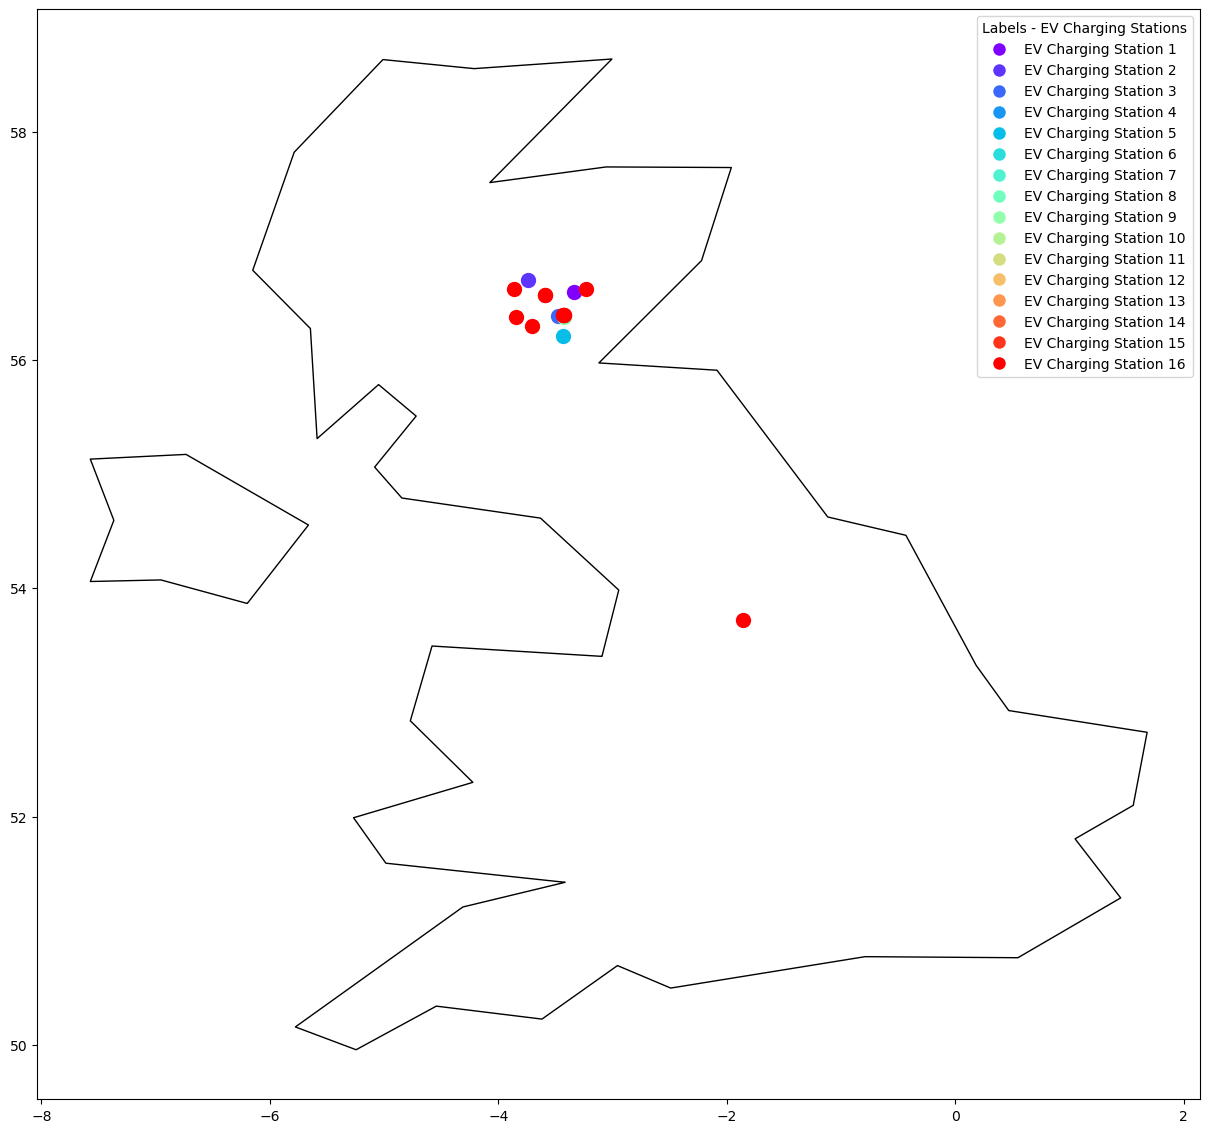

In [15]:
def plot_data(df):
    df = df.copy()  # Create a copy to avoid SettingWithCopyWarning

    # Check if the coordinates are strings that are formatted like tuples.
    # If so, convert them into actual tuples.
    df['coordinates'] = df['coordinates'].apply(
        lambda coord: tuple(map(float, coord.strip('()').split(','))) 
        if isinstance(coord, str) else coord
    )

    # Convert coordinates column to a geometry column
    df['geometry'] = df['coordinates'].apply(Point)

    # Convert DataFrame to GeoDataFrame
    gdf_all = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")  # Set the CRS to match the world data
    
    # Conventionally, the order of coordinates in a point geometry is (longitude, latitude)
    gdf_all['geometry'] = gdf_all['geometry'].apply(lambda x: Point(x.y, x.x))

    # Filter the GeoDataFrame to remove duplicate coordinates.
    gdf = gdf_all.drop_duplicates(subset=['coordinates'])

    cwd = os.getcwd()
    # Plot the data
    world = gpd.read_file(os.path.join(cwd, '..', 'data', 'raw', 'ne_110m_admin_0_countries', 'ne_110m_admin_0_countries.shp'))  # Use local path

    # We restrict to United Kingdom.
    fig, ax = plt.subplots(figsize=(15, 15))  # Increase the figsize to a desired size

    ax = world[world['ADMIN'] == 'United Kingdom'].plot(
        color='white', edgecolor='black', ax=ax
    )

    # We can now plot our GeoDataFrame if 'label' column exists.
    if 'Site_encoded' in gdf.columns:
        unique_colors = gdf['Site_encoded'].unique()
        color_map = cm.get_cmap('rainbow', len(unique_colors))  # Create a color map

        for i, row in gdf.iterrows():
            color = color_map(i)  # Get color based on index
            ax.plot(row['geometry'].x, row['geometry'].y, marker='o', markersize=10, color=color)  # Plot point with color

        # Create a legend for the colors
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f'EV Charging Station {i+1}', markerfacecolor=color_map(i), markersize=10) for i in range(len(unique_colors))]
        ax.legend(handles=legend_elements, title='Labels - EV Charging Stations', loc='upper right')

    # Set x and y limits to Scotland's rough boundary.
    ax.set_xlim([-8, -0.6])  # Rough boundary longitude of Scotland
    ax.set_ylim([54.6, 60.9])  # Rough boundary latitude of Scotland

    ax.axis('scaled')  # Set aspect ratio of the plot to be equal. This will ensure Scotland does not appear distorted.

    plt.show()

    gdf_all = gdf_all.drop('coordinates', axis=1)
    
    gdf_all.to_csv(os.path.join(cwd, '..', 'data', 'interim', 'train_gdf_forward_geocoded.csv'))

    return gdf_all, gdf  # Return the GeoDataFrame

gdf_all, gdf = plot_data(df)

In [16]:
len(gdf_all)

66664

In [17]:
gdf.head()

,Start DateTime,CP ID,Connector,Total kWh,Site,Model,End DateTime,Site_encoded,Model_encoded,Total kWh.1,coordinates,geometry
0,2016-01-09 07:21:00,50994,1,2.084,Leslie Street Car Park,APT Triple Rapid Charger,2016-01-09 07:27:00,0.0,3.0,2.084,"(56.59132102107761, -3.338015029709677)",POINT (-3.33802 56.59132)
1,2016-01-09 07:51:00,50281,2,3.870,"Rie-Achan Road Car Park, Pitlochry",APT 22kW Dual Outlet,2016-01-09 09:01:00,19.0,0.0,3.870,"(56.7034231, -3.738820533577715)",POINT (-3.73882 56.70342)
2,2016-01-09 08:22:00,50285,1,13.930,Broxden Park & Ride,APT 22kW Dual Outlet,2016-01-09 14:32:00,3.0,0.0,13.930,"(56.386610000000005, -3.4777460635074835)",POINT (-3.47775 56.38661)
4,2016-01-09 09:22:00,50745,2,3.580,Kinross Park and Ride,APT Triple Rapid Charger,2016-01-09 09:37:00,13.0,3.0,3.580,"(56.2067285, -3.432945)",POINT (-3.43295 56.20673)
8,2016-01-09 11:21:00,50275,1,10.210,Perth & Kinross Council - Friarton Depot,APT 7kW Dual Outlet,2016-01-09 14:16:00,9.0,2.0,10.210,"(56.37659640296878, -3.4239012108677493)",POINT (-3.42390 56.37660)


In [18]:
gdf_all.head()

,Start DateTime,CP ID,Connector,Total kWh,Site,Model,End DateTime,Site_encoded,Model_encoded,Total kWh.1,geometry
0,2016-01-09 07:21:00,50994,1,2.084,Leslie Street Car Park,APT Triple Rapid Charger,2016-01-09 07:27:00,0.0,3.0,2.084,POINT (-3.33802 56.59132)
1,2016-01-09 07:51:00,50281,2,3.870,"Rie-Achan Road Car Park, Pitlochry",APT 22kW Dual Outlet,2016-01-09 09:01:00,19.0,0.0,3.870,POINT (-3.73882 56.70342)
2,2016-01-09 08:22:00,50285,1,13.930,Broxden Park & Ride,APT 22kW Dual Outlet,2016-01-09 14:32:00,3.0,0.0,13.930,POINT (-3.47775 56.38661)
3,2016-01-09 08:54:00,50281,1,10.380,"Rie-Achan Road Car Park, Pitlochry",APT 22kW Dual Outlet,2016-01-09 16:37:00,19.0,0.0,10.380,POINT (-3.73882 56.70342)
4,2016-01-09 09:22:00,50745,2,3.580,Kinross Park and Ride,APT Triple Rapid Charger,2016-01-09 09:37:00,13.0,3.0,3.580,POINT (-3.43295 56.20673)
